In [1]:
import sys
sys.path.append('../pcqc')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pcqc import *

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [38]:
output_plots = 'pbmc_plots/resampling.pdf'
plot_dictionary = dict()

In [2]:
import scipy

In [3]:
import scanpy as sc

In [4]:
sim_data = pd.read_csv('data/pbmc_original_data.csv')

In [5]:
sim_data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1830,1831,1832,1833,1834,1835,1836,1837,reduced_clustering,truth_names
0,0,-0.171470,-0.280812,-0.046677,-0.475169,-0.544024,4.928497,-0.038028,-0.280573,-0.341788,...,-0.102943,-0.222116,-0.312401,-0.121678,-0.521229,-0.098269,-0.209095,-0.531203,0,CD8
1,1,-0.214582,-0.372653,-0.054804,-0.683391,0.633951,-0.334837,-0.045589,-0.498264,-0.541914,...,0.007155,-0.445372,1.629285,-0.058662,-0.857163,-0.266844,-0.313146,-0.596654,2,CD4 T
2,2,-0.376888,-0.295085,-0.057527,-0.520972,1.332648,-0.309362,-0.103108,-0.272526,-0.500799,...,-0.071774,-0.297857,-0.410920,-0.070431,-0.590720,-0.158656,-0.170876,1.379000,2,CD4 T
3,3,-0.285241,-0.281735,-0.052227,-0.484929,1.572680,-0.271825,-0.074552,-0.258875,-0.416752,...,-0.093818,-0.247770,2.552079,-0.097402,1.631684,-0.119462,-0.179120,-0.505669,1,CD14+
4,4,-0.256484,-0.220394,-0.046800,-0.345859,-0.333409,-0.208122,-0.069514,5.806440,-0.283112,...,-0.167350,-0.098665,-0.275836,-0.139482,-0.310095,-0.006877,-0.109614,-0.461946,3,NK


In [6]:
sim_data.shape

(2638, 1841)

In [7]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)   

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [9]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)

In [10]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [12]:
sc.pp.log1p(adata)

/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [13]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [14]:
adata = adata[:, adata.var.highly_variable]

In [15]:
adata.X

<2638x1838 sparse matrix of type '<class 'numpy.float32'>'
	with 408743 stored elements in Compressed Sparse Row format>

In [16]:
adata.X.nonzero()

(array([   0,    0,    0, ..., 2637, 2637, 2637], dtype=int32),
 array([   5,   13,   17, ..., 1806, 1808, 1816], dtype=int32))

In [17]:
data = pd.DataFrame.sparse.from_spmatrix(adata.X)

In [18]:
total_data = pd.concat([data,sim_data['truth_names']], axis = 1)

In [19]:
total_data['truth_names'].unique()

array(['CD8', 'CD4 T', 'CD14+', 'NK', 'Other', 'B Cells',
       'FCGR3A Monocytes', 'Dendritic', 'Megakaryocytes'], dtype=object)

In [41]:
total_data['truth_names'].value_counts()

CD4 T               768
CD14+               545
Other               444
CD8                 292
B Cells             255
NK                  159
FCGR3A Monocytes    106
Dendritic            55
Megakaryocytes       14
Name: truth_names, dtype: int64

In [42]:
new_data['truth_names'].value_counts().reset_index()

,index,truth_names
0,CD4 T,688
1,CD14+,475
2,Other,406
3,CD8,254
4,B Cells,229
5,NK,138
6,FCGR3A Monocytes,93
7,Dendritic,33
8,Megakaryocytes,12


In [20]:
total_data['weights'] = 1

In [21]:
total_data.loc[total_data['truth_names'] == 'Dendritic', 'weights'] = .5

In [22]:
new_data = total_data.sample(n = 2328, replace = False, 
                             random_state = 2, weights = total_data['weights'])

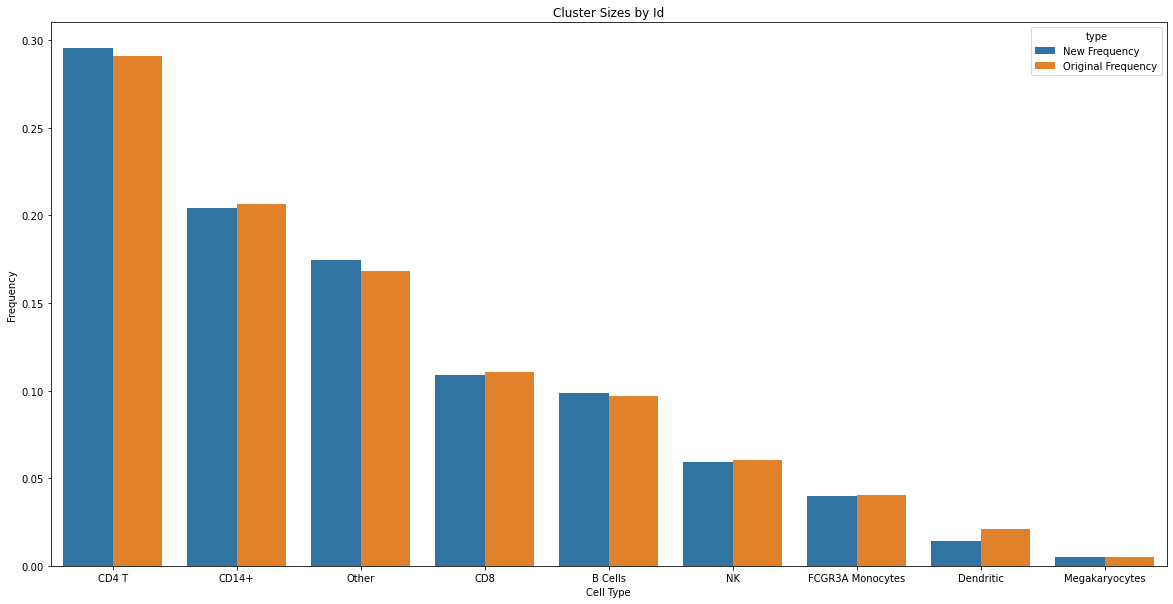

In [44]:
plt.figure(figsize=(20,10))
count_df = new_data['truth_names'].value_counts().reset_index()
count_df['truth_names'] = count_df['truth_names']/np.sum(count_df['truth_names'])
count_df2 = total_data['truth_names'].value_counts().reset_index()
count_df2['truth_names'] = count_df2['truth_names']/np.sum(count_df2['truth_names'])
count_df2['type'] = 'Original Frequency'
count_df['type'] = 'New Frequency'
count_df = pd.concat([count_df,count_df2])
sns.barplot(x="index", y="truth_names", data=count_df, hue = 'type')
plt.title('Cluster Sizes by Id')
plt.xlabel('Cell Type')
plt.ylabel('Frequency')
plot_dictionary['ClusterSizes'] = plt.gca().get_figure()

In [23]:
new_data['truth_names'].value_counts()

CD4 T               688
CD14+               475
Other               406
CD8                 254
B Cells             229
NK                  138
FCGR3A Monocytes     93
Dendritic            33
Megakaryocytes       12
Name: truth_names, dtype: int64

In [24]:
new_data.columns

Index([            0,             1,             2,             3,
                   4,             5,             6,             7,
                   8,             9,
       ...
                1830,          1831,          1832,          1833,
                1834,          1835,          1836,          1837,
       'truth_names',     'weights'],
      dtype='object', length=1840)

In [25]:
cols = [var for var in new_data.columns if var not in ['truth_names','weights']]

In [26]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [27]:
#trick scanpy into filtering additional cells.
#so that I can make assignment later
#will want to clean this up later

In [28]:
sc.pp.filter_cells(adata, min_genes=100)

Trying to set attribute `.obs` of view, copying.


In [29]:
adata

AnnData object with n_obs × n_vars = 2328 × 1838 
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [30]:
adata.X = new_data[cols].values

In [31]:
adata

AnnData object with n_obs × n_vars = 2328 × 1838 
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [32]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [33]:
adata.X

array([[-0.10941371,  1.81278416, -0.00670635, ..., -0.02189088,
        -0.07794149,  0.9859726 ],
       [ 1.44705919, -0.19916775, -0.01173237, ..., -0.01876304,
        -0.08626134, -0.35953965],
       [-0.08400768, -0.1150032 , -0.00595699, ..., -0.01063621,
        -0.06949817, -0.33967609],
       ...,
       [-0.08013368, -0.12079936, -0.00650612, ..., -0.01003191,
        -0.07024583, -0.33264522],
       [-0.11388184, -0.11440416, -0.0046615 , ..., -0.02022218,
        -0.07274906,  1.02304457],
       [-0.09974709, -0.09358495, -0.00386796, ..., -0.01332937,
        -0.06689618, -0.36897695]])

In [34]:
adata.X.shape

(2328, 1838)

In [35]:
sc.pp.scale(adata, max_value=10)

In [36]:
adata.write('pbmc_sample_preprocess.h5ad')

In [45]:
with PdfPages(output_plots) as pdf:
    for title in plot_dictionary.keys():
        pdf.savefig(plot_dictionary[title])

In [ ]:
#resample data